# Lab 02 : Multi Layer Perceptron

In [92]:
import numpy

### Forward Propogation of a Perceptron

Task 1: Implement the forward propogation of a single perceptron using only numpy and python functions.


A single perceptron can be used for binary classification. Perceptron can be used to implement only linearly seprable functions.

The perceptron would look like something as follows:

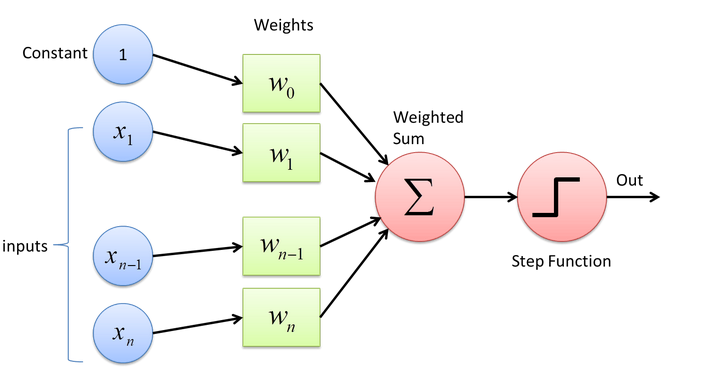

Source: https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53



Mathematically the Perceptron equation looks as follows :-


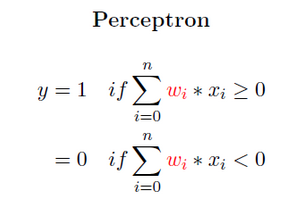
Source : https://towardsdatascience.com/perceptron-the-artificial-neuron-4d8c70d5cc8d




Where W1 , W1.. Wn are the weights and X1 , X2 ,...Xn are the inputs. Furthere their is a non-linear activation function f(a) that gives output out.

Here , W0 is the bias which in the equation can be taken as b.

a = x1*w1 + x2*w2 + x3*w3 + b   # Weighted Sum
z = f(a)                        # Activation Function

In our case the the activation is ReLu

The non-linear activation function is the ReLU function which is defined as follows:


            x, if x > 0
ReLU(x) = 
            
            0, otherwise
             
Complete the Perceptron Class given below


In [96]:
def relu(x):
    """ Implements the ReLU function. """
    if x > 0:
        return x

    return 0

class Neuron:
    
    def __init__(self):
        """ Class that depicts a single neuron. 
            Input dimension of this neuron is 3. """

        self.bias = -0.2
        self.weights = [-0.5, 0.1, 0.7]
        self.input_dim = 3
    
    def propagate(self, X):
        """ For each instance, calculate a and then z.
        
            Parameters
            ----------
            X: list of lists
                The input instances. """
        
        outputs = list()
        for x in X:
            z = self._weighted_sum(x)
            a = self._activation_function(z)
            outputs.append(a)
            
        return outputs

    def _weighted_sum(self, inputs):
        """ Calculate the weighted sum from one instance.
            
            Parameters
            ----------
            inputs: list of numbers
                e.g. [0.1, 0.2, 0.7]. """
        
        dot_product = 0
        for i in range(self.input_dim):
            dot_product += self.weights[i]*inputs[i]

        dot_product += self.bias

        return dot_product

    def _activation_function(self, x):
        """ Returns ReLU(x). """
        return relu(x)

In [97]:
inputs = [[0.1, 0.2, 0.7], [0.5, 0.9, 0.1], [0.02, 0.1, 0.7]]

In [98]:
neuron = Neuron()
outputs = neuron.propagate(inputs)

In [99]:
outputs

[0.25999999999999995, 0, 0.2899999999999999]

A perceptron is made up of just one neuron. So we can make a wrapper class over the neuron to model a Perceptron. The following part is just for demonstrating this. Don't change anything.

This demonstrates one forward pass of a perceptron. The next step is to calculate the losses using the errors and change weights by backpropagation.



In [100]:
class Perceptron:
    
    def __init__(self):
        self.neuron = Neuron()
        
    def train(self, X_train, y_train):    
        self.X_train = X_train
        self.y_train = y_train
        
        self.errors = []
        self.activations = self.forward_propagate()
        self.errors = self.calculate_errors()
        
    def forward_propagate(self):
        return self.neuron.propagate(self.X_train)
    
    def calculate_errors(self):
        errors = [self.activations[i] - self.y_train[i] for i in range(len(self.y_train))]
        return errors

In [101]:
perceptron = Perceptron()
perceptron.train(inputs, [0.3, 0.01, 0.33])
perceptron.errors

[-0.040000000000000036, -0.01, -0.04000000000000009]

## Multilayer Perceptron Network

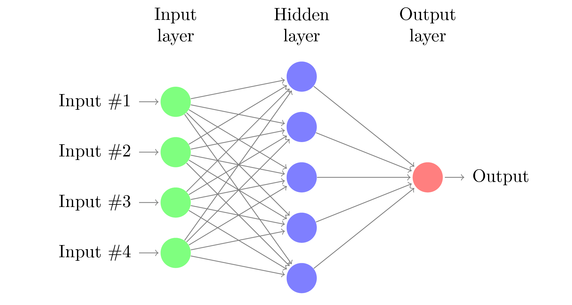

Source:http://www.texample.net/tikz/examples/neural-network/

Now that we have seen a single perceptron we will try to use the above concepts to make MLP network using Numpy from scratch

Now there are some building blocks that we will be using :-

 - <b>Dense Layer</b> : A fully connected Neural Net Layer.
             
               f(X) = W . X + b
               
               W : Matrix of weights
               X : Inputs
               b : Bias
               
 - <b>Activation Layer</b> : Layer to introduce non linearlity (Why is this important?)
 - <b>Loss Function</b> : (Binary or Cross Entropy Loss)
 - <b>Back Propogation Algorithm</b> : a stochastic gradient descent algortihm
 
 
 You can go through the code for the exact architecture to incoporate these blocks

In [91]:
import numpy as np
import matplotlib.pyplot as plt


### Functions for plotting graphs

In [9]:


def plot_loss(epoch_his, train_loss_his, test_loss_his):
    train_line, = plt.plot(epoch_his,train_loss_his,label = 'train')
    test_line, = plt.plot(epoch_his,test_loss_his,label = 'test')
    plt.xlabel('EPOCHS')
    plt.ylabel('Loss')
    plt.legend([train_line, test_line] , ['train','test'])
    plt.show()

def plot_accuracy(epoch_his, train_acc_his, test_acc_his):
    train_line, = plt.plot(epoch_his,train_acc_his,label = 'train')
    test_line, = plt.plot(epoch_his,test_acc_his,label = 'test')
    plt.xlabel('EPOCHS')
    plt.ylabel('Accuracy')
    plt.legend([train_line, test_line] , ['train','test'])
    plt.show()



### Activation Function

In [10]:

def relu(z):
    """
    Relu Activation
    Inputs:
    - z : A 2D numpy array
    """
    return (z > 0 ) * z

def relu_back(z):
    """
    Backpropogation for Relu Activation
    Inputs:
    - z : A 2D numpy array
    """
    return (z>0).astype(np.float64)

### Loss Function

In [11]:

def binary_cross_entropy(pred , Y):
    """
    The binary cross entropy loss.
    Note
    -pred should be in range [0,1]
    -Y should be a binary vector
    Inputs
    -pred: a numpy array reprsenting predictions made by the model
    -Y : a numpy  array representing the target variable
    Note that shape(pred) = shape(Y)
    Returns
    - loss : a scalar value to represent the loss
    - d_pred : a vector of the same shape as pred. It represents the error
            to be used for backpropogation(shape(d_pred) = shape(pred))
    """

    # clipping the inputs so there is no overflow
    epsilon = 1e-11
    pred = np.clip(pred , epsilon, 1 - epsilon)
    divisor = np.maximum(pred * (1-pred),epsilon)

    N = Y.shape[0]

    first_term = Y * np.log(pred)
    second_term = (1 - Y) * np.log(1 - pred)
    loss = -1  * np.mean( first_term + second_term ,axis =0)
    d_pred = np.nan_to_num((pred - Y) / (divisor * float(N)))

    return loss,d_pred

### Metric Function

In [12]:

def accuracy_binary(pred , Y):
    """
    Computes the zero one accuracy for a binary classificatiion
    Inputs:
    -pred: Column vector representing probabilities of Class == 1
    -Y: Binary column vector
    """
    pred =pred > 0.5
    acc = np.sum(pred == Y)
    acc = float(acc) / len(Y)
    return acc

 <b> We will first implement a Perceptron Layer Class</b>

In [72]:
class PerceptronLayer:
    """
    A fully connected layer for a neural network with RelU activation.
    This will be used to make a MultiLayerPerceptron that uses modular design.
    (The neural network architecture is defined by the user.)
    Note that this class does not implement any learning function. This class
    is to initialize layers in a multi layer perceptron model efficiently.
    The learnable parameters of the model are stored in as variables _self.W_,_self.b_
    """

    def __init__(self,l0,l1):
        """
        Initialize a layer of the network
        Inputs:
         - l0: an integer giving size of the input i.e. the size of previous layer
         - l1: an integer giving size of the output i.e the size of layer
         - activation: a string giving activation function of this layer
                    (default value:'linear')
        """
        self.W = np.random.randn(l0 ,l1).astype(np.float64)# * np.sqrt(2.0 /l0 )
        self.b = np.zeros((l1)).astype(np.float64)

        # self.grad = {'W':np.zeros((l0,l1)).astype(np.float64) ,
        #             'b':np.zeros((l1)).astype(np.float128) }

        self.act_fn = relu
        self.act_fn_back = relu_back

        print(self.W.shape , self.b.shape)
        print(self.act_fn)

    def forward(self,X):
        """
        This function performs the Forward propogation of a layer
        """

        #print(X.shape , self.W.shape , self.b.shape)
        h_x = X.dot(self.W) + self.b

        a = self.act_fn(h_x)
        # print(a)
        return a,h_x



    def update_batch_gradient_descent(self , X , h_x , d_back,alpha = 0.01):
        """
        This function performs the weight update of a layer using the Gradient descent optimizer
        Inputs:
        - X : The input to the layer
        - h_x : The predicted output of the layer
        - d_back : Gradients from front layers calculated using backpropogation
        - alpha : The learning rate (Default : 0.01)
        """

        # dloss/d(a) * d(a) / d(h_x)
        
        d_h_x = self.act_fn_back(h_x) * d_back
        #Derivating w.r.t W
        # dloss/d(h_x) * d(h_x) / d(W)
        # print((d_h_x).shape)

        d_W = X.T.dot(d_h_x)

        #Derivatng w.r.t b
        # dloss/d(h_x) * d(h_x) / d(b)
        d_b = d_h_x

        #Derivating w.r.t x(to return to previous layers)
        # dloss/d(h_x) * d(h_x) / d(X)
        d_X = d_h_x.dot(self.W.T)

        #Update W
        #print("W_before = ", self.W)
        delta_W = d_W
        self.W = self.W - alpha * delta_W
        #print("W_after = ",self.W)

        #Update b
        delta_b = np.sum(d_b , axis =0)
        self.b = self.b - alpha * delta_b

        d_back = d_X
        
        return d_back


In [81]:

class MultiLayerPerceptron:
    """
    This is the class for making a multi-layer neural network by using the PerceptronLayer class
    """

    def __init__(self ,layer_list = None):
        """
        Initialize the neural networks by creating objects of the PerceptronLayer class
        Inputs:
         - layer_list: list of layer sizes
         - activation_list: list of activation functions for each layer
        """

        if layer_list == None:
            raise Exception('layer_list cant be empty')
        
        self.hidden_layers= len(layer_list) - 1

        self.layers = {}
        
        for i in range(self.hidden_layers):
            self.layers[i+1] = PerceptronLayer(layer_list[i] , layer_list[i+1])


    def forward(self , X):
        """
        This function performs the forward propogation on the neural network
        Inputs:
        - X : Input to the neural network
        """

        a = X
        cache = []
        cache.append(a)
        for i in range(self.hidden_layers):
            a,h_x = self.layers[i+1].forward(a)
            cache.append(h_x)

        return a,cache

    def update_gradient(self, cache, d_back , alpha=0.01):
        """
        This function performs backpropogation and uses the Gradient descent optimizer for updating weights
        Inputs :
        - cache : The values required for backpropogation corresponing to a layer
        - d_back : The gradients from front layers during backpropogation
        - alpha : the learningrate (default : 0.01)
        """

        for i in range(self.hidden_layers , 0 , -1):
            
            d_back = self.layers[i].update_batch_gradient_descent(cache[i-1],cache[i],d_back,alpha)

        return d_back


    def train(self,
            X_train,
            Y_train,
            X_test,
            Y_test,
            metric_fn = accuracy_binary,
            loss_fn = binary_cross_entropy,
            epochs=200,
            record_at = 100,
            verbose = True,
            learning_rate =0.1,
            learning_rate_decay = False):

        """
        This function trains the neural network
        Inputs:
        - X_train : The training dataset
        - Y_train : The training target values
        - X_test : The testing dataset
        - Y_test : The testing target values
        - metric : The metric function for assesing the model (default : accuracy_binary)
        - loss_function_string : The loss function (default : mean_square_error)
        - epochs : The number of epochs for which the model will be trained (default : 200)
        - record_at :  The epoch interval at which the loss and metric will be recorded (default : 100)
        - Verbose : Display the statistics, metrics and progress of the model while training (default : True)
        - learning_rate : the learning rate (default : 0.1)
        - learning_rate_decay : Decaying the learning rate (default : False)
        """
        
        """
        DO NOT TOUCH
        
        """

        
        train_loss_his = []
        train_acc_his = []
        test_loss_his = []
        test_acc_his = []
        epoch_his = []

        for i in range(epochs):
            prediction , cache = self.forward(X_train)
            
            
            loss,d_back= loss_fn(prediction,Y_train)
            self.update_gradient(cache,d_back,learning_rate)
            if learning_rate_decay:
                learning_rate *= (1.0 / 1.0 + i)



            if i % record_at == 0:
                train_loss,_ = loss_fn(prediction,Y_train)
                train_acc = metric_fn(prediction,Y_train)

                test_prediction , _ = self.forward(X_test)
                test_loss,_ = loss_fn(test_prediction,Y_test)
                test_acc = metric_fn(test_prediction,Y_test)

                train_loss_his.append(train_loss)
                train_acc_his.append(train_acc)
                test_loss_his.append(test_loss)
                test_acc_his.append(test_acc)
                epoch_his.append(i)

                if verbose:
                    print("{}th EPOCH:\nTraining Loss:{}|Training Accuracy:{}|Test Loss:{}|Test Accuracy:{}".\
                      format(i , train_loss , train_acc,test_loss,test_acc))
        train_loss_his = np.array(train_loss_his).reshape(-1)
        train_acc_his = np.array(train_acc_his).reshape(-1)
        test_loss_his = np.array(test_loss_his).reshape(-1)
        test_acc_his = np.array(test_acc_his).reshape(-1)
        epoch_his = np.array(epoch_his).reshape(-1)
        return train_loss_his,train_acc_his,test_loss_his,test_acc_his,epoch_his
     
    def metric_function(self,X,Y,metric_fn=accuracy_binary):
        
        prediction , _ = self.forward(X)
        acc = metric_fn(prediction,Y)
        return acc

In [82]:
#############################################
## Declaring Training Data        ############
#############################################
X_train = np.array([[0,0],[1,0],[0,1],[1,1]])
Y_train = np.array([[1],[0],[0],[0]])



In [83]:
# Declare a neuron with shape of weights as [shape_of_input,1]
model = MultiLayerPerceptron([2,1])

((2, 1), (1,))
<function relu at 0x7f4d24aa4848>


In [84]:
# testing the model outputs
pred, _ = model.forward(X_train)

In [85]:
#Testing the model before training

loss,d_back = binary_cross_entropy(pred,Y_train)
print("The loss is {}\nAnd the error to be back propogated is:\n {}".format(loss , d_back))

The loss is [ 6.33896007]
And the error to be back propogated is:
 [[ -2.50000000e+10]
 [  2.50000000e-01]
 [  2.56945803e-01]
 [  2.50000000e-01]]


In [88]:
# Now we can train the model by iteratively on each datapoint.
layer_list = [2,3,1]

model = MultiLayerPerceptron(layer_list)



train_loss_his,train_acc_his,test_loss_his,test_acc_his,epoch_his=model.train(X_train,
            Y_train,
            X_train,
            Y_train,
            metric_fn = accuracy_binary,
            loss_fn=binary_cross_entropy,
            epochs=1000,
            record_at=100)

((2, 3), (3,))
<function relu at 0x7f4d24aa4848>
((3, 1), (1,))
<function relu at 0x7f4d24aa4848>
0th EPOCH:
Training Loss:[ 25.32843596]|Training Accuracy:0.0|Test Loss:[ 6.33210901]|Test Accuracy:0.75
100th EPOCH:
Training Loss:[ 6.33210901]|Training Accuracy:0.75|Test Loss:[ 6.33210901]|Test Accuracy:0.75
200th EPOCH:
Training Loss:[ 6.33210901]|Training Accuracy:0.75|Test Loss:[ 6.33210901]|Test Accuracy:0.75
300th EPOCH:
Training Loss:[ 6.33210901]|Training Accuracy:0.75|Test Loss:[ 6.33210901]|Test Accuracy:0.75
400th EPOCH:
Training Loss:[ 6.33210901]|Training Accuracy:0.75|Test Loss:[ 6.33210901]|Test Accuracy:0.75
500th EPOCH:
Training Loss:[ 6.33210901]|Training Accuracy:0.75|Test Loss:[ 6.33210901]|Test Accuracy:0.75
600th EPOCH:
Training Loss:[ 6.33210901]|Training Accuracy:0.75|Test Loss:[ 6.33210901]|Test Accuracy:0.75
700th EPOCH:
Training Loss:[ 6.33210901]|Training Accuracy:0.75|Test Loss:[ 6.33210901]|Test Accuracy:0.75
800th EPOCH:
Training Loss:[ 6.33210901]|Trainin

In [89]:


# Now we can predict the values for unseen data or trained data also
# We can also calculate the accuracy of the model we have trained
model.metric_function(X_train,Y_train,metric_fn = accuracy_binary)


0.75

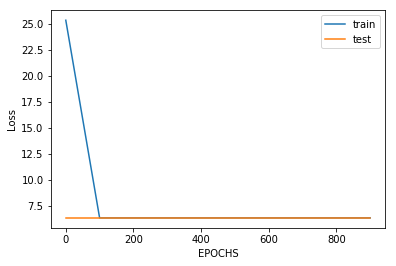

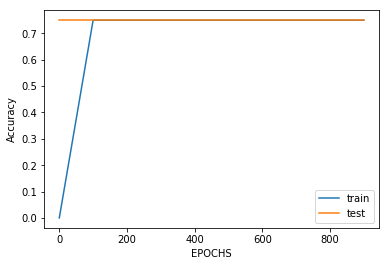

In [90]:
plot_loss(epoch_his,train_loss_his,test_loss_his)
plot_accuracy(epoch_his,train_acc_his,test_acc_his)

# Multiclass Classification (MNIST Data)

### Loss Function

In [11]:

def softmax_multiclass_cross_entropy(pred ,Y):
    """
    The multiclass cross entropy loss with a softmax activation.
    Note
    -Use this loss when softmax(defined in [[Activations.py]]) is used as activation for the last layer.
    -pred should be in range [0,1]
    -Y should be Column vector of one hot row vectors
    Inputs
    -pred: a numpy array reprsenting predictions made by the model
    -Y : a numpy  array representing the target variable
    Note that shape(pred) = shape(Y)
    Returns
    - loss : a scalar value to represent the loss
    - d_pred : a vector of the same shape as pred. It represents the error
            to be used for backpropogation(shape(d_pred) = shape(pred))
    """
    epsilon = 1e-11
    pred = np.clip(pred , epsilon , 1 - epsilon)
    loss = np.mean(-np.sum(np.log(pred)*Y, axis = 1) , axis = 0)
    d_pred = pred - Y
    return loss,d_pred

### Metric Function

In [102]:
def accuracy_multiclass(pred, Y):
    """
    Computes the zero one accuracy for a Multiclass classificatiion
    Inputs:
    -pred: Column vector representing probabilities of Class == 1
    -Y: Column vector of one hot row vectors
    """
    #print("acc, pred = ",pred)
    #print("acc, Y = ",Y)
    acc = np.sum(pred.argmax(1)==Y.argmax(1))
    acc = float(acc) / len(Y)
    return acc

In [ ]:
# NOW WILL LOAD VISUALIZE AND TRAIN THE MODEL